In [8]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

# Setting the ticker symbols for NASDAQ and NSE indices
nasdaq_ticker = "^IXIC"  # NASDAQ
nse_ticker = "^NSEI"     # NSE

# Collect historical data for NASDAQ
nasdaq_data = yf.download(nasdaq_ticker, start="2010-01-01", end="2023-06-01")

# Collect historical data for NSE
nse_data = yf.download(nse_ticker, start="2010-01-01", end="2023-06-01")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [9]:
#Used to extract the closing prices of the indexes
nasdaq_close = nasdaq_data['Close']
nse_close = nse_data['Close']

In [12]:
data = pd.DataFrame({'NASDAQ': nasdaq_close, 'NSE': nse_close})
#Used to find the rerurns for the index

data['NASDAQ_Return'] = data['NASDAQ'].pct_change()
data['NSE_Return'] = data['NSE'].pct_change()

# Find the correlation between returns
correlation = data['NASDAQ'].corr(data['NSE'])

print(correlation)

0.9511577006729953


In [13]:
if correlation > 0:
    lead_index = 'NASDAQ'
    lag_index = 'NSE'
else:
    lead_index = 'NSE'
    lag_index = 'NASDAQ'

# Print the lead-lag relationship
print("The potential lead-lag relationship:")
print(lead_index, "leads", lag_index)

The potential lead-lag relationship:
NASDAQ leads NSE


<function matplotlib.pyplot.show(close=None, block=None)>

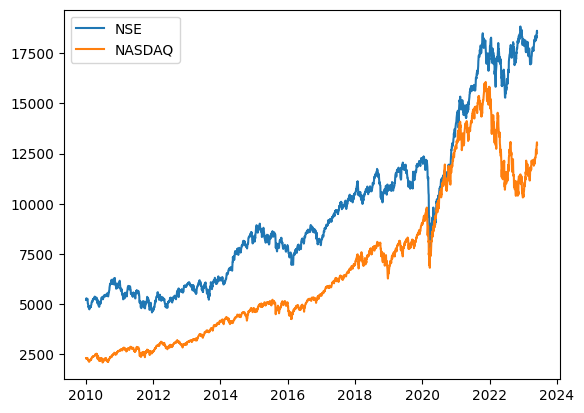

In [15]:
#Plotting the lead lag relationship
nse_price=(nse_data.High+nse_data.Low)/2
nasdaq_price=(nasdaq_data.High+nasdaq_data.Low)/2

plt.plot(nse_price, label='NSE')
plt.plot(nasdaq_price, label='NASDAQ')
plt.legend()
plt.show

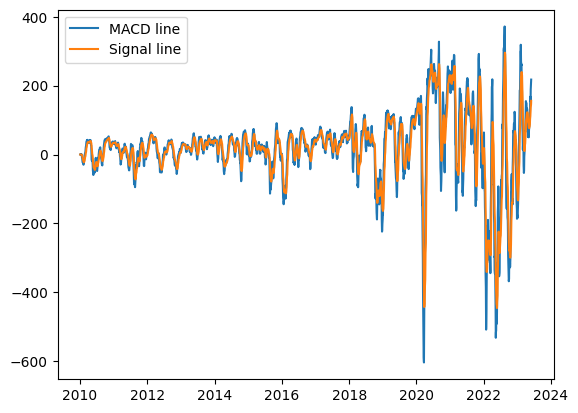

In [16]:
#MACD
MACD_line = nasdaq_data.Close.ewm(span = 12).mean() - nasdaq_data.Close.ewm(span = 26).mean()
Signal_line = MACD_line.ewm(span = 14).mean()
plt.plot(MACD_line, label='MACD line')
plt.plot(Signal_line, label='Signal line')
plt.legend()


In [27]:
#Implementing MACD
nse_data['macd_line'] = nse_data.Close.ewm(span = 10).mean() - nse_data.Close.ewm(span = 21).mean()
nse_data['signal_line'] = nse_data['macd_line'].ewm(span = 20).mean()

nse_data['Buy_Signal'] = np.where(nse_data['macd_line'] > nse_data['signal_line'], 1, 0)
nse_data['Sell_Signal'] = np.where(nse_data['macd_line'] < nse_data['signal_line'], 1, 0)
nse_data['daily_returns'] =(nse_data['Close']-nse_data['Open'])/nse_data['Open']
nse_data['loc'] = np.where(nse_data['Buy_Signal'] >nse_data['Sell_Signal'], nse_data['daily_returns'], -nse_data['daily_returns'])
NSE_macd_cumulative_return= (nse_data['loc'] + 1).product() -1

nse_data['cumulative_rolling_max'] = (nse_data['loc'] + 1).cumprod()-1
drawdown = NSE_macd_cumulative_return - nse_data['cumulative_rolling_max']
NSE_macd_Max_drawdown = np.min(drawdown)

annual_returns= nse_data['loc'].mean()*252
risk_free_rate = 0.05
annual_std_dev = nse_data['loc'].std()*np.sqrt(252)
NSE_macd_Sharpe_ratio=(annual_returns-risk_free_rate) / annual_std_dev

print("Max Drawdown:",NSE_macd_Max_drawdown)
print("Cumulative Return:",NSE_macd_cumulative_return)
print("Sharpe Ratio:",NSE_macd_Sharpe_ratio)

Max Drawdown: -0.5518578718485969
Cumulative Return: 21.135420507694157
Sharpe Ratio: 1.368283338118865


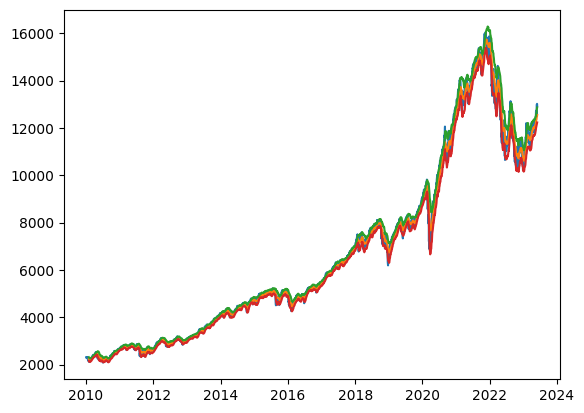

In [28]:
#Keltner Channel
import numpy as np
import matplotlib.pyplot as plt

True_range = pd.DataFrame([nasdaq_data.High - nasdaq_data.Low, abs(nasdaq_data.High - nasdaq_data.Close.shift(1)), abs(nasdaq_data.Low - nasdaq_data.Close.shift(1))]).max()
ATR = True_range.rolling(14).mean()
Middle = nasdaq_data['Close'].ewm(span = 20, min_periods = 20).mean()
upper = Middle + 2*ATR
lower = Middle - 2*ATR

plt.plot(nasdaq_data.Close)
plt.plot(Middle)
plt.plot(upper)
plt.plot(lower)

In [29]:
True_range = pd.DataFrame([nse_data.High - nse_data.Low, abs(nse_data.High - nse_data.Close.shift(1)), abs(nse_data.Low - nse_data.Close.shift(1))]).max()
nse_data['ATR'] = True_range.rolling(18).mean()
nse_data['Middle'] = nse_data['Close'].ewm(span=20, min_periods=20).mean()
nse_data['upper'] = nse_data['Middle'] + 2 * nse_data['ATR']
nse_data['lower'] = nse_data['Middle'] - 2 * nse_data['ATR']

nse_data['Buy_Signal'] = np.where(nse_data['Close'] < nse_data['lower'], 1, 0)
nse_data['Sell_Signal'] = np.where(nse_data['Close'] > nse_data['upper'], 1, 0)
nse_data['daily_returns'] = (nse_data['Close'] - nse_data['Open']) / nse_data['Open']
nse_data['loc'] = np.where(nse_data['Buy_Signal'] > nse_data['Sell_Signal'], nse_data['daily_returns'], -nse_data['daily_returns'])
NSE_keltner_cumulative_return = (nse_data['D_R'] + 1).product() - 1

nse_data['cumulative_rolling_max'] = (nse_data['loc'] + 1).cumprod() - 1
drawdown = NSE_keltner_cumulative_return - nse_data['cumulative_rolling_max']
NSE_keltner_Max_drawdown = np.min(drawdown)

annual_returns = nse_data['loc'].mean() * 252
risk_free_rate = 0.05
annual_std_dev = nse_data['loc'].std() * np.sqrt(252)
NSE_keltner_Sharpe_ratio = (annual_returns - risk_free_rate) / annual_std_dev

print("Max Drawdown:", NSE_keltner_Max_drawdown)
print("Cumulative Return:", NSE_keltner_cumulative_return)
print("Sharpe Ratio:", NSE_keltner_Sharpe_ratio)

Max Drawdown: -0.844943113167197
Cumulative Return: -0.7613150838953304
Sharpe Ratio: -1.0268399426407113


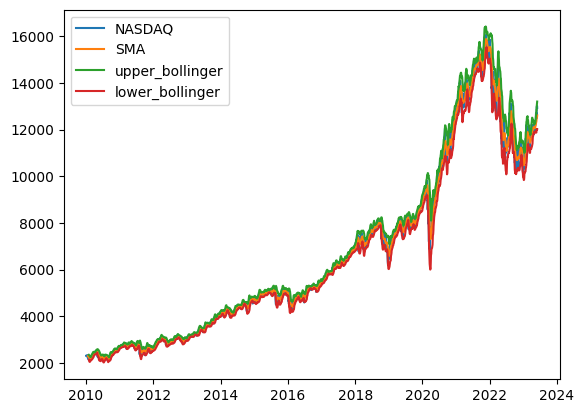

In [31]:
#bollinger band
SMA = nasdaq_data.Close.rolling(14).mean()
tp = (nasdaq_data.High + nasdaq_data.Close + nasdaq_data.Low)/3
sd = tp.rolling(20).std()
upper_bollinger = SMA + 2*sd
lower_bollinger = SMA - 2*sd

plt.plot(nasdaq_data.Close , label='NASDAQ')  
plt.plot(SMA,label='SMA')
plt.plot(upper_bollinger, label='upper_bollinger')
plt.plot(lower_bollinger, label='lower_bollinger')
plt.legend()

In [34]:
nse_data['SMA'] = nse_data.Close.rolling(180).mean()
nse_data['tp'] = (nse_data.Close + nse_data.High + nse_data.Low)/3
sd = nse_data.t_p.rolling(50).std()
nse_data['upper_bollinger'] = nse_data.SMA + 2*sd
nse_data['lower_bollinger'] = nse_data.SMA - 2*sd
nse_data['Buy_Signal'] = np.where(nse_data['Close'] < nse_data['lower_bollinger'], 1, 0)
nse_data['Sell_Signal'] = np.where(nse_data['Close'] > nse_data['upper_bollinger'], 1, 0)
nse_data['daily_returns'] =(nse_data['Close']-nse_data['Open'])/nse_data['Open']
nse_data['loc'] = np.where(nse_data['Buy_Signal'] > nse_data['Sell_Signal'], nse_data['daily_returns'], -nse_data['daily_returns'])
NSE_bb_cumulative_return= (nse_data['loc'] + 1).product() -1

nse_data['cumulative_rolling_max'] = (nse_data['loc'] + 1).cumprod()-1
drawdown = NSE_bb_cumulative_return - nse_data['cumulative_rolling_max']
NSE_bb_Max_drawdown = np.min(drawdown)

annual_returns= nse_data['loc'].mean()*252
risk_free_rate = 0.05
annual_std_dev = nse_data['loc'].std()*np.sqrt(252)
NSE_bb_Sharpe_ratio=(annual_returns-risk_free_rate) / annual_std_dev

print("Max Drawdown:",NSE_bb_Max_drawdown)
print("Cumulative Return:",NSE_bb_cumulative_return)
print("Sharpe Ratio:",NSE_bb_Sharpe_ratio)

Max Drawdown: -0.09404739875049328
Cumulative Return: 0.2181582547858667
Sharpe Ratio: -0.1673007185601404
